# Stage 1: Enhanced Data Cleaning, Preprocessing, Exploratory Analysis and Topic Modeling
In this notebook, we perform **data cleaning, preprocessing, and exploratory analysis (EDA)** on the Cleantech Media and Google Patent datasets. The goal is to identify **trends, key technologies, and innovation gaps** by analyzing media publications and patents. Furthermore we are going to use some **topic modeling techniques** to discover hidden themes and topics in the datasets.

In [ ]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install contractions
!pip install unidecode
!pip install num2words
!pip install pyspellchecker
!pip install langdetect
!pip install symspellpy

In [ ]:
!wget https://raw.githubusercontent.com/wolfgarbe/SymSpell/master/SymSpell/frequency_dictionary_en_82_765.txt

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import re
import nltk
import spacy
import string
import contractions
import unidecode
from tqdm import tqdm
from num2words import num2words
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
# from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from spellchecker import SpellChecker
from symspellpy import SymSpell, Verbosity
from langdetect import detect
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from wordcloud import WordCloud
from collections import Counter
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from sklearn.feature_extraction.text import CountVectorizer

## Data Collection and Cleaning (Joshua)
Before analyzing the data, we first **load, inspect, and clean** the datasets:  

- **Load datasets**: We import the **Cleantech Media Dataset** and the **Cleantech Google Patent Dataset** into Pandas DataFrames.  
- **Remove duplicates**: Identical or near-identical entries are removed to prevent data bias.  
- **Handle missing values**: We check for null or incomplete entries and decide whether to impute, replace, or remove them.  
- **Filter relevant information**: Non-informative texts (e.g., generic statements) are removed to ensure high-quality analysis.  

In [ ]:
# Load raw data
data_folder = Path("/content/drive/MyDrive/computational-language-technology-project")
media_dataset_path = data_folder / "data/cleantech_media_dataset_v3_2024-10-28.csv"
google_patent_dataset_path = data_folder / "data/CleanTech_22-24_updated.json"

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

## Cleantech Media Dataset

In [ ]:
# Load CSV files
df_media = pd.read_csv(media_dataset_path, header = 0)

print(df_media.info())
df_media

In [ ]:
# Count occurrences of each unique value in the 'domain' column
domain_counts = df_media['domain'].value_counts()

# Display the counts
print(domain_counts)

In [ ]:
# Create a new dataframe for the processed data
df_media_preprocessed = df_media.rename(columns={df_media.columns[0]: 'id'})
df_media_preprocessed.drop(columns=['author'], inplace=True)

TEXT HERE

In [ ]:
# Extract the 'content' for each ID
content_23099 = df_media_preprocessed[df_media_preprocessed['id'] == 23099]['content'].values[0]
content_23100 = df_media_preprocessed[df_media_preprocessed['id'] == 23100]['content'].values[0]

# Create a comparison table
comparison_table = pd.DataFrame({
    'ID 23099 Content': [content_23099],
    'ID 23100 Content': [content_23100]
})

# Display the table
print(comparison_table)

In [ ]:
# Convert columns to the required data types
df_media_preprocessed['title'] = df_media_preprocessed['title'].astype(str)
df_media_preprocessed['content'] = df_media_preprocessed['content'].astype(str)
df_media_preprocessed['domain'] = df_media_preprocessed['domain'].astype(str)
df_media_preprocessed['url'] = df_media_preprocessed['url'].astype(str)
df_media_preprocessed['date'] = pd.to_datetime(df_media_preprocessed['date'], errors='coerce')
df_media_preprocessed['id'] = df_media_preprocessed['id'].astype(int)

# Check for duplicates
duplicate_ids = df_media_preprocessed[df_media_preprocessed.duplicated(subset=['id'])]
print(duplicate_ids)


df_media_preprocessed

In [ ]:
# List of unwanted suffixes
unwanted_suffixes = [
    "Need help finding the right suppliers?",
    "Energy XPRT is part of XPRT Media All Rights Reserved. Terms Privacy",
    "Your email address will not be published. Required fields are marked",
    "Hi, I 'm Azthena, you can trust me to find commercial scientific answers",
    "Copyright",
    "To use the full function of this web site",
    "EcoFriend.com ",
    "EuropÃ¤ische Vereinigung",
    "Get updates on the IEA",
    "About us",
    "This website uses cookies to",
    "Recharge is part of DN Media Group",
    "Solar Industry offers industry participants probing",
    "Thank you for subscribing to the email newsletter",
    "This site uses Akismet to reduce spam"
]

# Define the prefixes to remove
unwanted_prefixes = [
    "By clicking `` Allow All '' you agree ",
    "We use cookies to enhance your experience",
    "Sign in to get the best natural gas news and data",
    "Your email address *",
    "Your password *",
    "Remember me Continue",
    "Reset password",
    "Featured Content",
    "News & Data Services",
    "Client Support",
    "- May 27, 2022 - With the innovation and development",
    "A consortium of Mitsubishi Power Americas",
    "Advanced Energy's WaveCapture",
    "Check out a tour of Solar Turbines ' Configurable Modular",
    "Benefits of Combined Heat & Power ( Cogeneration) Website",
    "window.dojoRequire",
    "Accurate Wind Resource Assessment. Power Performance Verification",
    "Create a free IEA account to download",
    "Equip yourself with various operating voltages and advanced control",
    "FLOWSTAR-Energy is a practical, high resolution model "
    "Hydrogen Technology Expo & Carbon Capture Technology Expo was held in Bremen",
    "By Power Vision Engineering Sarl based in Ecublens",
    "Power Vision Engineering provides various...",
    "Shenzhen Power Kingdom Co., Ltd. is one of the subsidiaries of Henan Yuguang Gold",
    "This course investigates",
    "This course examines",
    "Welcome to Edinburgh Instruments",
    "Create a free IEA account to download our reports or subcribe"
]

def remove_unwanted_prefixes(content):
    if isinstance(content, str):
        try:
            content_list = eval(content)
            if isinstance(content_list, list):
                content_list = [
                    item for item in content_list
                    if not any(item.startswith(prefix) for prefix in unwanted_prefixes)
                ]
                return str(content_list)  # Convert back to string if needed
        except:
            pass  # Ignore errors if content is not a valid list
    return content

# Function to remove everything after any of the unwanted phrases
def remove_unwanted_suffixes(content):
    if isinstance(content, str):
        for phrase in unwanted_suffixes:
            index = content.find(phrase)
            if index != -1:
                return content[:index].strip()  # Keep only the part before the phrase
    return content

df_media_preprocessed['content'] = df_media_preprocessed['content'].apply(remove_unwanted_suffixes)
df_media_preprocessed['content'] = df_media_preprocessed['content'].apply(remove_unwanted_prefixes)

In [ ]:
# Extract the 'content' for each ID
content_23099 = df_media_preprocessed[df_media_preprocessed['id'] == 23099]['content'].values[0]
content_23100 = df_media_preprocessed[df_media_preprocessed['id'] == 23100]['content'].values[0]

# Create a comparison table
comparison_table = pd.DataFrame({
    'ID 23099 Content': [content_23099],
    'ID 23100 Content': [content_23100]
})

# Display the table
print(comparison_table)

In [ ]:
save_path = "/content/drive/MyDrive/computational-language-technology-project/cleaned_data/media_dataset_pre-cleaned.csv"
df_media_preprocessed.to_csv(save_path, index=False)

## Cleantech Google Patent Dataset

In [ ]:
df_google_patents = pd.read_json(google_patent_dataset_path, lines=True)
print(df_google_patents.info())
df_google_patents

In [ ]:
df_counts = df_google_patents["publication_number"].value_counts().reset_index()
df_counts.columns = ["publication_number", "count"]
df_counts = df_counts.sort_values(by="count", ascending=False)

print(df_counts)

Differences between those duplicates are in either theirs language or their cpc code. The cpc  (Cooperative Patent Classification) code is part of a classification system used to categorize patents based on their technical content.

**Structure of CPC Codes:**

CPC codes are hierarchical and consist of:

- Section (e.g., Y)
- Class (e.g., Y02)
- Subclass (e.g., Y02B)
- Group (e.g., Y02B10)
- Subgroup (e.g., Y02B10/10 or Y02B10/20)

A single patent can be classified under multiple CPC codes if its invention covers aspects of different categories.

To get rid of all those duplicates, the text in the column "title" and "abstract" shall be checked if it is in english. If yes, the entry shall be kept and else the duplicate is removed:

In [ ]:
# Function to check if text is in English
def is_english(text):
    try:
        return detect(text) == "en"
    except:
        return False  # Handle cases where text is empty or cannot be detected

# Select all publication numbers from df_counts
publication_numbers_to_check = df_counts["publication_number"].tolist()

# Filter the main dataframe to only include these publication numbers
df_filtered = df_google_patents[df_google_patents["publication_number"].isin(publication_numbers_to_check)]

# Initialize progress bar for language detection
tqdm.pandas(desc="Checking language")

# Apply language detection on the filtered dataset
df_filtered["is_english"] = df_filtered.progress_apply(
    lambda row: is_english(str(row["title"])) and is_english(str(row["abstract"])), axis=1
)

# Count total and English entries
total_count = len(df_filtered)
english_count = df_filtered["is_english"].sum()

print(f"Total rows processed: {total_count}")
print(f"English rows detected: {english_count}")

# Filter only English rows
df_english = df_filtered[df_filtered["is_english"]]

# Drop duplicates and keep the first English entry per publication_number
df_google_patents_preprocessed = df_english.drop_duplicates(subset="publication_number", keep="first")

# Check the results
df_google_patents_preprocessed.info()


In [ ]:
df_google_patents_preprocessed

In [ ]:
save_path = "/content/drive/MyDrive/computational-language-technology-project/cleaned_data/google_patent_pre-cleaned.csv"
df_google_patents_preprocessed.to_csv(save_path, index=False)

## Text Preprocessing (Joshua)
To ensure that the text data is **ready for NLP tasks**, we preprocess it using common natural language processing (NLP) techniques:  

- **Tokenization**: Split text into individual words or subwords for better analysis.  
- **Stopword Removal**: Common but uninformative words (e.g., "the", "is", "and") are removed.  
- **Stemming**: Words are reduced to their root form (e.g., "developing" → "develop").  
- **Lowercasing**: Standardize all text to lowercase to avoid duplicate entries.  

These steps improve the quality of text-based analysis and ensure consistency across datasets.

In [ ]:
PUNCTUATIONS = string.punctuation
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
STOPWORDS = set(stopwords.words('english'))
stemmer = PorterStemmer()
nltk.download('wordnet')
spell = SpellChecker()
# Initialize SymSpell
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)

# Load dictionary from the local file
dictionary_path = "frequency_dictionary_en_82_765.txt"
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)



In [ ]:
def remove_emails(text):
    return re.sub(r'\S+@\S+', '', text) if isinstance(text, str) else text

def remove_dates(text):
    text = re.sub(r'\d{1,2}(st|nd|rd|th)?[-./]\d{1,2}[-./]\d{2,4}', '', text)
    pattern = re.compile(r'(\d{1,2})?(st|nd|rd|th)?[-./,]?\s?(of)?\s?([J|j]an(uary)?|[F|f]eb(ruary)?|[Mm]ar(ch)?|[Aa]pr(il)?|[Mm]ay|[Jj]un(e)?|[Jj]ul(y)?|[Aa]ug(ust)?|[Ss]ep(tember)?|[Oo]ct(ober)?|[Nn]ov(ember)?|[Dd]ec(ember)?)\s?(\d{1,2})?(st|nd|rd|th)?\s?[-./,]?\s?(\d{2,4})?')
    text = pattern.sub(r'', text)
    return text if isinstance(text, str) else text

def remove_html(text):
    clean_text = BeautifulSoup(text).get_text()
    return clean_text

def remove_tags_mentions(text):
    pattern = re.compile(r'(@\S+|#\S+)')
    return pattern.sub('', text)

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCTUATIONS))

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in STOPWORDS])

def remove_whitespaces(text):
    return " ".join(text.split())

def freq_words(text):
    tokens = word_tokenize(text)
    counter = Counter(tokens)
    FrequentWords = [word for word, _ in counter.most_common(10)]
    return FrequentWords

def remove_fw(text):
    FrequentWords = freq_words(text)
    tokens = word_tokenize(text)
    without_fw = [word for word in tokens if word not in FrequentWords]
    return ' '.join(without_fw)

def rare_words(text):
    tokens = word_tokenize(text)
    counter = Counter(tokens)
    RareWords = []
    number_rare_words = 10
    for word, word_count in counter.most_common()[-number_rare_words:]:
        RareWords.append(word)
    return RareWords

def remove_rw(text):
    RareWords = rare_words(text)
    tokens = word_tokenize(text)
    without_rw = [word for word in tokens if word not in RareWords]
    return ' '.join(without_rw)

def nums_to_words(text):
    new_text = []
    for word in text.split():
        # Check if the word has a number followed by a non-digit (e.g., 45x, 122gw, 122%, etc.)
        match = re.match(r"(-?\d+)([a-zA-Z%]+)?", word)

        if match:
            num_part = match.group(1)  # The number part
            suffix = match.group(2)    # The suffix (if any)

            try:
                num_in_words = num2words(num_part)
                if suffix:
                    # Ensure the number and suffix are correctly formatted
                    new_text.append(f"{num_in_words} {suffix}")
                else:
                    new_text.append(num_in_words)
            except Exception as e:
                new_text.append(word)  # In case of an error, keep the original word
        else:
            new_text.append(word)

    return " ".join(new_text)

def stem_words(text):
    return ' '.join([stemmer.stem(word) for word in text.split()])

def accented_to_ascii(text):
    return unidecode.unidecode(text)

In [ ]:
def correct_spelling(text):
    if pd.isna(text):  # Handle NaN values
        return text

    words = text.split()
    corrected_words = []

    for word in words:
        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)
        corrected_words.append(suggestions[0].term if suggestions else word)  # Use the best suggestion

    return " ".join(corrected_words)

### df_media

In [ ]:
data_folder = Path("/content/drive/MyDrive/computational-language-technology-project")
media_preprocessed_path = data_folder / "cleaned_data/media_dataset_pre-cleaned.csv"

In [ ]:
df_media_processed = pd.read_csv(media_preprocessed_path, header = 0)

In [ ]:
# lower casing
df_media_processed['content'] = df_media_processed['content'].apply(lambda x: x.lower())

# Call all removals
df_media_processed['content'] = df_media_processed['content'].map(remove_emails)
df_media_processed['content'] = df_media_processed['content'].map(remove_dates)
df_media_processed['content'] = df_media_processed['content'].map(remove_html)
df_media_processed['content'] = df_media_processed['content'].map(remove_tags_mentions)
df_media_processed['content'] = df_media_processed['content'].map(remove_punctuation)
df_media_processed['content'] = df_media_processed['content'].map(remove_stopwords)
df_media_processed['content'] = df_media_processed['content'].map(remove_whitespaces)
df_media_processed['content'] = df_media_processed['content'].map(remove_fw)
df_media_processed['content'] = df_media_processed['content'].map(remove_rw)
df_media_processed['content'] = df_media_processed['content'].map(nums_to_words)
df_media_processed['content'] = df_media_processed['content'].map(stem_words)
df_media_processed['content'] = df_media_processed['content'].map(accented_to_ascii)

df_media_processed

Correct all spelling errors from the preprocessing

In [ ]:
tqdm.pandas(desc="Checking spelling")
df_media_processed.loc[:, 'content'] = df_media_processed.loc[:, 'content'].map(correct_spelling)
df_media_processed

To save some time, we save the processed/cleaned dataframe to directly load it for further steps:

In [ ]:
save_path = "/content/drive/MyDrive/computational-language-technology-project/cleaned_data/media_dataset_cleaned.csv"
df_media_processed.to_csv(save_path, index=False)

### df_google_patents

In [ ]:
data_folder = Path("/content/drive/MyDrive/computational-language-technology-project")
google_patents_preprocessed_path = data_folder / "cleaned_data/google_patent_pre-cleaned.csv"

In [ ]:
df_google_patents_processed = pd.read_csv(google_patents_preprocessed_path, header = 0)

In [ ]:
# Lower casing
df_google_patents_processed["abstract"] = df_google_patents_processed["abstract"].apply(lambda x: x.lower())

# Call all removals
df_google_patents_processed["abstract"] = df_google_patents_processed["abstract"].map(remove_emails)
df_google_patents_processed["abstract"] = df_google_patents_processed["abstract"].map(remove_dates)
df_google_patents_processed["abstract"] = df_google_patents_processed["abstract"].map(remove_html)
df_google_patents_processed["abstract"] = df_google_patents_processed["abstract"].map(remove_tags_mentions)
df_google_patents_processed["abstract"] = df_google_patents_processed["abstract"].map(remove_punctuation)
df_google_patents_processed["abstract"] = df_google_patents_processed["abstract"].map(remove_stopwords)
df_google_patents_processed["abstract"] = df_google_patents_processed["abstract"].map(remove_whitespaces)
df_google_patents_processed["abstract"] = df_google_patents_processed["abstract"].map(remove_fw)
df_google_patents_processed["abstract"] = df_google_patents_processed["abstract"].map(remove_rw)
df_google_patents_processed["abstract"] = df_google_patents_processed["abstract"].map(nums_to_words)
df_google_patents_processed["abstract"] = df_google_patents_processed["abstract"].map(stem_words)
df_google_patents_processed["abstract"] = df_google_patents_processed["abstract"].map(accented_to_ascii)

df_google_patents_processed

In [ ]:
df_google_patents_processed.loc[:, 'abstract'] = df_google_patents_processed.loc[:, 'abstract'].progress_apply(correct_spelling)
df_google_patents_processed

In [ ]:
save_path = "/content/drive/MyDrive/computational-language-technology-project/cleaned_data/google_patent_cleaned.csv"
df_google_patents_processed.to_csv(save_path, index=False)

## Exploratory Data Analysis (Chris)
EDA helps us **understand data patterns and distributions** before applying complex NLP models. We perform:  

- **Temporal Analysis**: We examine **publication trends** over time to detect emerging Cleantech topics.  
- **Named Entity Recognition (NER)**: Identify key **companies, organizations, and technologies** frequently mentioned in the datasets.  
- **Word Frequency Analysis**: Find the most common words and phrases across media and patents.  
- **Visualization**:  
  - **Word Clouds** to showcase frequently occurring terms  
  - **Bar Charts** to compare key industry players and technology mentions  
  - **Network Graphs** to analyze relationships between companies and technologies  

In [ ]:
# Load the datasets
media_df = pd.read_csv('../cleaned_data/media_dataset_cleaned.csv')
patent_df = pd.read_csv('../cleaned_data/google_patent_cleaned.csv')

In [ ]:
# Display basic info
print("Media Dataset:")
print(media_df.info())
print(media_df.head())

print("\nPatent Dataset:")
print(patent_df.info())
print(patent_df.head())

In [ ]:
# Temporal Analysis
media_df['date'] = pd.to_datetime(media_df['date'], errors='coerce')
patent_df['publication_date'] = patent_df['publication_date'].astype(str).str[:4] + '-' + patent_df['publication_date'].astype(str).str[4:6] + '-' + patent_df['publication_date'].astype(str).str[6:]
patent_df['publication_date'] = pd.to_datetime(patent_df['publication_date'], errors='coerce')
# Extract month and year for binning
media_df['month_year'] = media_df['date'].dt.to_period('M').astype(str)
patent_df['month_year'] = patent_df['publication_date'].dt.to_period('M').astype(str)
media_df['month'] = media_df['date'].dt.month
patent_df['month'] = patent_df['publication_date'].dt.month

In [ ]:
# Plot distribution by month.year
plt.figure(figsize=(12, 5))
media_df['month_year'].value_counts().sort_index().plot(kind='bar', figsize=(15, 5))
plt.title("Distribution of Articles Over Time (Month-Year)")
plt.xlabel("Month-Year")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

The upper bar chart represents the distribution of media articles over time (grouped by Month-Year). A key observation is the extreme spike in June 2023, where the number of articles is significantly higher than any other month. Other months show a more balanced and steady distribution, with a gradual increase in early 2023 and stabilization afterward.

In June 2023, a significant spike in cleantech media coverage was observed, likely due to multiple high-profile industry events. Key events included the Cleantech Forum Asia (Singapore), the ARC Cleantech Innovation Festival (Germany), and the CleanTech Innovation Showcase (Seattle).

The concentration of these global events likely contributed to the increased volume of cleantech-related articles in June 2023.

In [ ]:
plt.figure(figsize=(12, 5))
patent_df['month_year'].value_counts().sort_index().plot(kind='bar', figsize=(15, 5))
plt.title("Distribution of Patents Over Time (Month-Year)")
plt.xlabel("Month-Year")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

The graph illustrates the monthly distribution of patents from January 2022 to September 2024. Patent activity fluctuates, with a notable peaks in August 2022 and June 2023. A significant drop is observed in February 2023. From early 2024 onward, a gradual decline in patent filings is evident, with a sharp drop after April 2024. This decline may indicate incomplete recent data, decreasing patent activity, or shifts in R&D investment.

In [ ]:
# We will add some basic text features to the data

# Add 'Review lenght'
media_df['title_length'] = media_df['title'].astype(str).apply(len)
# Add simple token count
media_df['number_tokens'] = media_df['title'].apply(lambda x: len(str(x).split()))

# Add 'Review lenght'
patent_df['abrtract_length'] = patent_df['abstract'].astype(str).apply(len)
# Add simple token count
patent_df['abstract_tokens'] = patent_df['abstract'].apply(lambda x: len(str(x).split()))


In [ ]:
media_df.describe()

The distribution suggests that most article titles are relatively short, but some outliers have significantly longer titles.

In [ ]:
patent_df.describe()

This suggests that while most patents follow a standardized format, there is significant variation in abstract length and detail, possibly reflecting different technical fields or patent submission styles.

In [ ]:
media_df.groupby('domain').size().sort_values(ascending=False)

The table shows the number of articles per media domain. Energy-Xprt (4,181), PV-Magazine (3,093), and Azocleantech (2,488) are the top sources, indicating their strong presence in cleantech reporting. The data follows a long-tail distribution, with a few domains contributing most articles, while niche sources like Biofuels-News (1) and BEX Asia (2) provide minimal coverage. This helps identify key players in the sector.

In [ ]:
patent_df.groupby('country_code').size().sort_values(ascending=False)


In [ ]:
plt.figure(figsize=(12, 5))
patent_df['country_code'].value_counts().sort_index().plot(kind='bar', figsize=(15, 5))
plt.title("Cleantech-Related Patent Distribution by Country")
plt.xlabel("Country")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

The grouped data shows the number of patents filed per country, sorted in descending order. China (CN) dominates with 26,208 patents, significantly higher than the United States (US) with 881 and WO (World Intellectual Property Organization) with 698. Other notable regions include Europe (EP), South Korea (KR), Australia (AU), and Canada (CA). The distribution highlights China's overwhelming lead in patent filings, suggesting a strong focus on cleantech innovation and intellectual property protection.

In [ ]:
# Set figure size
plt.figure(figsize=(12, 6))

# Create boxplot for abstract length by country
sns.boxplot(data=patent_df, x='country_code', y='abrtract_length', showfliers=False)

# Customize plot
plt.xlabel("Country Code")
plt.ylabel("Abstract Length")
plt.title("Distribution of Abstract Length by Country")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.show()

The boxplot highlights variations in patent abstract lengths across countries. While some nations have consistently longer or shorter abstracts, it is important to consider the number of patents per country, as nations with fewer patents may show more variability. High-patent countries like CN, US, and EP provide a broader representation, whereas outliers in smaller datasets may not reflect overall trends. 

### Sentiment
The following code performs sentiment analysis on text data from two datasets using the VADER SentimentIntensityAnalyzer from the nltk library. The goal is to assess the sentiment polarity of media content and patent abstracts by computing a compound sentiment score for each entry.

For each text entry, the polarity score is calculated using VADER’s polarity_scores() method, which returns a dictionary of sentiment scores. The compound score, a single value ranging from -1 (strongly negative) to +1 (strongly positive), is extracted and assigned to a new column 'sentiment'. This score helps to quantitatively assess the sentiment of media content and patent abstracts, enabling further analysis on trends, emotional tone, and public perception. 

In [ ]:
# Sentiment Analysis
sia = SentimentIntensityAnalyzer()
media_df['sentiment'] = media_df['content'].fillna('').apply(lambda x: sia.polarity_scores(str(x))['compound'])
patent_df['sentiment'] = patent_df['abstract'].fillna('').apply(lambda x: sia.polarity_scores(str(x))['compound'])

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(media_df['sentiment'], bins=20, kde=True)
plt.title("Sentiment Distribution in Media Articles")
plt.xlabel("Sentiment Score")
plt.ylabel("Count")
plt.show()

The sentiment analysis of media articles shows a strong positive bias, with most sentiment scores clustering around +1.0. Negative and neutral sentiments are significantly less frequent. This suggests that the media coverage in the dataset is predominantly positive.

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(patent_df['sentiment'], bins=20, kde=True)
plt.title("Sentiment Distribution in Patent Abstracts")
plt.xlabel("Sentiment Score")
plt.ylabel("Count")
plt.show()

The sentiment analysis of patent abstracts shows peaks around neutral (0.0) and positive (0.75-1.0) scores. Negative sentiments are less frequent but still present, indicating that patent abstracts tend to be either neutral or slightly optimistic in tone.

In [ ]:
media_df.plot(kind='scatter', x='title_length', y='sentiment', figsize=(15,7))
plt.xlabel('Title Length')
plt.ylabel('Sentiment')
plt.title('Scatter Plot of Title Length vs Sentiment')
plt.show()

Most titles are short (<100 characters) and strongly positive (1.0 sentiment). Longer titles are rare and show mixed sentiment. No clear correlation between title length and sentiment. 

In [ ]:
patent_df.plot(kind='scatter', x='abrtract_length', y='sentiment', figsize=(15,7))
plt.xlabel('Abstract Length')
plt.ylabel('Sentiment')
plt.title('Scatter Plot of Abstract Length vs Sentiment')
plt.show()

Most abstracts are under 500 characters and show a wide range of sentiment values. Sentiment distribution appears balanced, with both positive and negative scores. Longer abstracts are rare and also as before do not show a clear sentiment trend. 

In [ ]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(media_df['title'], 20)
bigrams = pd.DataFrame(common_words, columns = ['word' , 'count'])

bigrams.plot(kind='barh', x='word', color='cadetblue', width=0.5, figsize=(5,6))
plt.xlabel('count')
plt.ylabel('word')
plt.title('Media Bigrams w/o stopwords')

The most common bigrams highlight key topics like solar energy, energy storage, and renewable energy. "PV magazine" appears most frequently, suggesting a major industry source. These terms indicate the primary focus areas in cleantech media.

In [ ]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(media_df['title'], 20)
trigrams = pd.DataFrame(common_words, columns = ['word' , 'count'])

trigrams.plot(kind='barh', x='word', color='cadetblue', width=0.5, figsize=(5,6))
plt.xlabel('count')
plt.ylabel('word')
plt.title('Media Trigrams w/o stopwords')

"PV magazine international" appears most frequently, reinforcing its role as a dominant industry source. The most frequent trigrams emphasize solar energy, energy storage, and energy management.

In [ ]:
common_words = get_top_n_bigram(patent_df['abstract'].dropna(), 20)
bigrams = pd.DataFrame(common_words, columns = ['word' , 'count'])

bigrams.plot(kind='barh', x='word', color='cadetblue', width=0.5, figsize=(5,6))
plt.xlabel('count')
plt.ylabel('word')
plt.title('Patent Bigrams w/o stopwords')

The most frequent bigrams highlight technical terminology such as "technic field," "invent disclose," and "solar energy." The frequent use of "model" and "relay" suggests a strong focus on engineering and innovation in patent documentation.

In [ ]:
common_words = get_top_n_trigram(patent_df['abstract'].dropna(), 20)
trigrams = pd.DataFrame(common_words, columns = ['word' , 'count'])

trigrams.plot(kind='barh', x='word', color='cadetblue', width=0.5, figsize=(5,6))
plt.xlabel('count')
plt.ylabel('word')
plt.title('Patent Trigrams w/o stopwords')

The trigrams further refine key concepts, with phrases like "relay technic field," "belong technic field," and "comprise follow step." These terms indicate a focus on technical processes, energy management, and patent disclosures.

### Named Entity Recognition (NER) using spaCy

In [ ]:
!python -m spacy download en_core_web_sm

In [ ]:
# Named Entity Recognition (NER) using spaCy
nlp = spacy.load("en_core_web_sm")

def extract_entities(text):
    doc = nlp(text)
    return [ent.text for ent in doc.ents if ent.label_ in ['ORG', 'PRODUCT']]
    

media_df['entities'] = media_df['content'].fillna('').apply(lambda x: extract_entities(str(x)))

In [ ]:
save_path = "../cleaned_data/media_dataset_cleaned_entity.csv"
media_df.to_csv(save_path, index=False)

In [ ]:
patent_df['entities'] = patent_df['abstract'].fillna('').apply(lambda x: extract_entities(str(x)))

In [ ]:
save_path = "../cleaned_data/google_patent_cleaned_entity.csv"
patent_df.to_csv(save_path, index=False)

In [ ]:
# Co-occurrence Matrix
entity_pairs = []
for entities in media_df['entities'].dropna():
    entity_pairs.extend([(e1, e2) for i, e1 in enumerate(entities) for e2 in entities[i+1:]])
for entities in patent_df['entities'].dropna():
    entity_pairs.extend([(e1, e2) for i, e1 in enumerate(entities) for e2 in entities[i+1:]])

co_occurrence = Counter(entity_pairs)
co_occurrence_df = pd.DataFrame(co_occurrence.items(), columns=['Pair', 'Count']).sort_values(by='Count', ascending=False)

# Visualizing Co-occurrence Matrix
plt.figure(figsize=(12, 6))
sns.barplot(y=co_occurrence_df['Pair'].astype(str)[:20], x=co_occurrence_df['Count'][:20], palette="viridis")
plt.xlabel("Count")
plt.ylabel("Entity Pair")
plt.title("Top 20 Entity Co-occurrences")
plt.show()

In [ ]:
# Graph Visualization
G = nx.Graph()
for (e1, e2), count in co_occurrence.items():
    G.add_edge(e1, e2, weight=count)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, with_labels=True, node_size=50, font_size=10)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(e1, e2): count for (e1, e2), count in co_occurrence.items() if count > 5}, font_size=8)
plt.title("Entity Co-occurrence Graph")
plt.show()

In [ ]:
# K-Means Clustering on Entity Co-occurrences
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
entity_texts = [' '.join(pair) for pair in co_occurrence_df['Pair']]
X = vectorizer.fit_transform(entity_texts)

num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, max_iter=50, tol=0.01, random_state=42)
kmeans.fit(X)
clusters = kmeans.labels_.tolist()

# Display Clustered Entities
centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = np.array(vectorizer.get_feature_names_out())
for i, cluster_terms in enumerate(centroids):
    print("Cluster #{}: {}".format(i, ", ".join(terms[cluster_terms[:8]])))

 ### Word Clouds
 Word Cloud Analysis
To visualize the most frequently used words in media articles and patent abstracts, we generate word clouds. This technique helps identify dominant themes and key terms by displaying words in varying sizes based on their frequency.

In [ ]:
# Word Clouds
media_text = ' '.join(media_df['content'].dropna().astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(media_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Media Articles")
plt.show()

The dominant terms include "two thousand," "projects,", "product," "industry" and "power". This suggests that the media coverage focuses heavily on industrial developments and energy projects related to cleantech.

The presence of numerical values like "one thousand," "twenty," and "thirty" indicates frequent mentions of years, financial figures, or project scales. Words such as "develop," "supply," "generate," and "design" emphasize a strong focus on innovation, infrastructure, and renewable energy initiatives.

In [ ]:
patent_text = ' '.join(patent_df['abstract'].dropna().astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(patent_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Patent Abstracts")
plt.show()

The word cloud for patent abstracts highlights key terms frequently appearing in the dataset. Dominant words such as "technic," "field," "disclose," "invent," and "provide" suggest a strong focus on technical innovation, disclosures, and inventions.

Terms like "solar," "energy," "relay," and "gene" indicate that many patents relate to renewable energy, electrical systems, and biotechnology. Additionally, words such as "structure," "process," and "assembly" emphasize the technical and engineering aspects of patent filings.

## Topic Modeling (Blerta)
To **identify hidden themes and emerging trends**, we apply topic modeling techniques on both datasets:  

- **Latent Dirichlet Allocation (LDA)** and **Non-Negative Matrix Factorization (NMF)** to uncover broad thematic structures.  
- **Top2Vec** and **BERTopic** for **more dynamic and context-aware topic modeling**.  
- **Comparing Media vs. Patents**:  
  - Which Cleantech topics are **gaining media attention** but **not patented** yet?  
  - Are **patents aligned with market trends**, or do they focus on different areas?  

By the end of this step, we will have a **structured view of the Cleantech landscape**, highlighting **key trends, players, and technological opportunities**.


In [1]:
# imports for topic modeling
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from top2vec import Top2Vec
import warnings
import logging
from bertopic import BERTopic
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt



### Patent Dataset

We are going to apply the above mentioned techniques first for the patent dataset, and afterwards for the media dataset.

In [2]:
## Lets again have a general look at the dataset to see what we are working with
# load patent dataset directly from the .csv file 
patent_modeling = pd.read_csv("../cleaned_data/google_patent_cleaned_entity.csv")  

patent_modeling.head(5)


,publication_number,application_number,country_code,title,abstract,publication_date,inventor,cpc_code,is_english,month_year,month,abrtract_length,abstract_tokens,sentiment,entities
0,CN-117151396-A,CN-202311109834-A,CN,Distributed economic scheduling method for win...,disclose method solar ethan firstly solar prov...,2023-12-01,"['HU PENGFEI', 'LI ZIMENG']",G06Q50/06,True,2023-12,12,371,53,-0.5267,[]
1,CN-117147382-A,CN-202310985511-A,CN,Device for monitoring hydrogen atom crossing g...,invent provide atom use spam relay technic fie...,2023-12-01,"['MA ZHAOXIANG', 'WANG CHENGXU', 'LIU ZHONGLI']",G01N13/00,True,2023-12,12,539,75,-0.3182,[]
2,CN-113344288-B,CN-202110717505-A,CN,Cascade hydropower station group water level p...,disclose device compute readable storage mediu...,2023-12-01,[],G06Q10/04,True,2023-12,12,330,46,0.0000,[]
3,CN-117153944-A,CN-202311209193-A,CN,"Heterojunction solar cell, preparation method ...",apply provide hetero solar cell prepare method...,2023-12-01,"['TONG HONGBO', 'JIN YUPENG']",H01L31/074,True,2023-12,12,328,44,0.8834,[]
4,CN-116911695-B,CN-202311167289-A,CN,Flexible resource adequacy evaluation method a...,invent relay method device electro system belo...,2023-12-01,[],H02J2203/20,True,2023-12,12,487,68,-0.8779,[]


#### NMF

In [ ]:
## preparation
abstract = patent_modeling["abstract"].fillna("")


In [ ]:
# step 1: TF-IDF transformation
vectorizer = TfidfVectorizer(max_features=1000, stop_words="english")
tfidf_matrix = vectorizer.fit_transform(abstract)

# step 2: NMF model training
nmf = NMF(n_components=10, random_state=42, l1_ratio=0.5)
W = nmf.fit_transform(tfidf_matrix)  
H = nmf.components_  

# step 3: show top words for each topic
feature_names = vectorizer.get_feature_names_out()

def print_top_words(model, feature_names, n_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics.append([f"Topic {topic_idx+1}"] + top_words)
    
    df_topics = pd.DataFrame(topics, columns=["Topic"] + [f"Word {i+1}" for i in range(n_top_words)])
    print(df_topics.to_string(index=False))

print("\nTopics in NMF model for the patent dataset:")
print_top_words(nmf, feature_names, 10)



#### LDA

In [ ]:

# Step 1: Convert the text data (abstract) to a TF-IDF matrix
vectorizer = TfidfVectorizer(max_features=1000, stop_words="english")
tfidf_matrix = vectorizer.fit_transform(abstract)

# Step 2: Fit the LDA model
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(tfidf_matrix)

# Step 3: print top words
def print_top_words_lda(model, feature_names, n_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics.append([f"Topic {topic_idx+1}"] + top_words)
    
    # Creating a DataFrame to display the results in a nice tabular format
    df_topics = pd.DataFrame(topics, columns=["Topic"] + [f"Word {i+1}" for i in range(n_top_words)])
    print(df_topics.to_string(index=False))

# Example usage after fitting the LDA model
print("\nTopics in LDA model for the patent dataset:")
print_top_words_lda(lda, vectorizer.get_feature_names_out(), 10)


#### top2Vec

In [ ]:
# Extract the 'abstract' column as a list of text documents
documents_patent = patent_modeling["abstract"].dropna().tolist()  # Drop NaN values

# Train Top2Vec model
model_patent = Top2Vec(documents_patent, speed="learn", workers=4)  # Adjusted speed to learn for medium quality
num_topics = model_patent.get_num_topics()

topics_words, word_scores, topic_nums = model_patent.get_topics()

for i in range(num_topics):
    words = topics_words[i]
    scores = word_scores[i]
    topic_num = topic_nums[i]
    
    print(f"Topic {topic_num}")
    for word, score in zip(words, scores):
        print(f"    {word} (score: {score:.4f})")
    print("\n")
    break




The scores represent the relevance or importance of that word to the given topic. These scores are often based on word embeddings and semantic similarity within the topic. 

The five words that appear in all three topic modeling results are:

- photovoltaic
- panel
- electro
- invent
- method

These words are consistently identified as significant across the different topic modeling approaches, indicating they are central themes in the dataset.


#### BERTopic

In [3]:
docs_patent = patent_modeling["abstract"].dropna().tolist()  # Drop NaN values

# BERTopic model
topic_model_patent = BERTopic()

# train the model on the patent data
topics, probs = topic_model_patent.fit_transform(docs_patent)

# show the most important topics
topic_model_patent.get_topic_info()


,Topic,Count,Name,Representation,Representative_Docs
0,-1,17267,-1_energy_solar_comprise_connect,"[energy, solar, comprise, connect, until, gene...",[until model disclose composite flatplat relay...
1,0,603,0_model_instal_panel_until,"[model, instal, panel, until, fix, support, si...",[until model disclose technic field environmen...
2,1,589,1_gene_blade_rotate_shaft,"[gene, blade, rotate, shaft, wind, power, end,...",[invent disclose office equip power comprise w...
3,2,553,2_hydropower_conserve_station_engin,"[hydropower, conserve, station, engin, model, ...",[until model disclose device water conserve hy...
4,3,545,3_optic_establish_consider_obtain,"[optic, establish, consider, obtain, step, con...",[invent provide regal optic configure model hi...
...,...,...,...,...,...
173,172,11,172_polyacrylamidegraphen_graphed_thousands_made,"[polyacrylamidegraphen, graphed, thousands, ma...",[relay technic field seaway dealing particular...
174,173,10,173_quench_or_in_cd,"[quench, or, in, cd, is, to, smelt, temper, al...",[invent provide hy950cf twenty thousands one u...
175,174,10,174_online_telescope_bush_thread,"[online, telescope, bush, thread, screen, rota...",[until model disclose energy relay technic fie...
176,175,10,175_hydrocarbon_pm_wet_describe,"[hydrocarbon, pm, wet, describe, deviceespeci,...",[describe method gene thermal energy deviceesp...


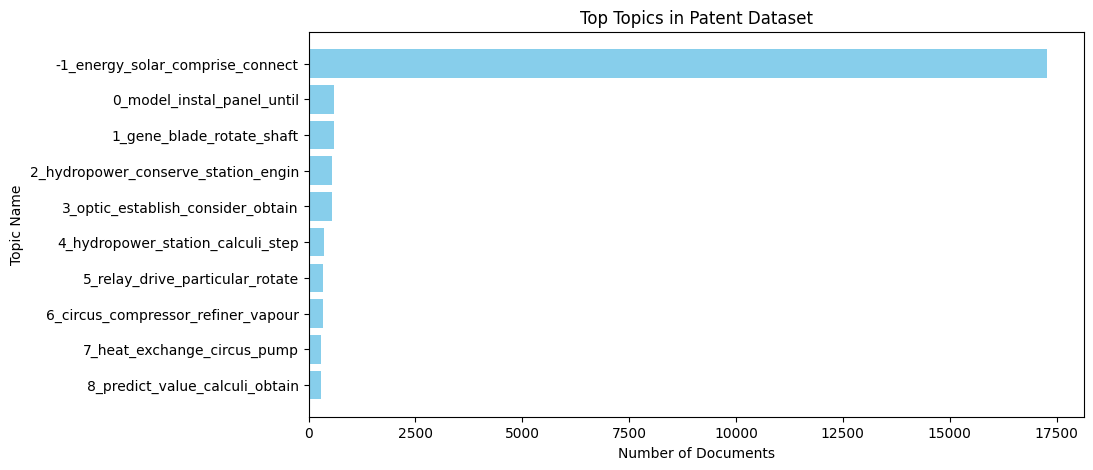

In [5]:
import matplotlib.pyplot as plt

topic_freq = topic_model_patent.get_topic_info()
top_n = 10  # Number of topics to show

plt.figure(figsize=(10, 5))
plt.barh(topic_freq["Name"][:top_n], topic_freq["Count"][:top_n], color="skyblue")
plt.xlabel("Number of Documents")
plt.ylabel("Topic Name")
plt.title("Top Topics in Patent Dataset")
plt.gca().invert_yaxis()  # Reverse order for better readability
plt.show()


**Key insights**:

Large proportion of outliers: Topic -1 contains 17,267 documents, indicating that many documents don't fit well into specific topics, probably due to data diversity.

Diverse topics on energy and technology: Topics cover a wide range of themes, including solar energy, wind power, hydropower, and optical technologies, indicating a strong focus on renewable energy and technological innovations.


### Media dataset

We will do the same now for the media dataset

In [7]:
# load cleaned dataset
media_modeling = pd.read_csv("../cleaned_data/media_dataset_cleaned_entity.csv")  

media_modeling.head(5)

,id,title,date,content,domain,url,month_year,month,title_length,number_tokens,sentiment,entities
0,93320,"XPeng Delivered ~100,000 Vehicles In 2021",2022-01-02,chines startup shown drama auto product campus...,cleantechnica,https://cleantechnica.com/2022/01/02/xpeng-del...,2022-01,1,41,6,0.9906,"['transit corp', 'ada']"
1,93321,Green Hydrogen: Drop In Bucket Or Big Splash?,2022-01-02,laid plan build largest product fail world int...,cleantechnica,https://cleantechnica.com/2022/01/02/its-a-gre...,2022-01,1,45,8,0.9081,"['china alliance', 'mitsubishi example', 'toyo..."
2,98159,World’ s largest floating PV plant goes online...,2022-01-03,intern switch array china a shandong deploy tw...,pv-magazine,https://www.pv-magazine.com/2022/01/03/worlds-...,2022-01,1,83,14,0.9198,"['suzhou china', 'kwh electro']"
3,98158,Iran wants to deploy 10 GW of renewables over ...,2022-01-03,iranian author current eight go project submit...,pv-magazine,https://www.pv-magazine.com/2022/01/03/iran-wa...,2022-01,1,93,17,-0.0057,[]
4,31128,Eastern Interconnection Power Grid Said ‘ Bein...,2022-01-03,daily dpi infrastructure i news access electro...,naturalgasintel,https://www.naturalgasintel.com/eastern-interc...,2022-01,1,71,11,0.9814,['naturalgasintelcom']


#### NMF

In [ ]:
# Same for the media dataset
## preparation
content = media_modeling["content"].fillna("")

# step 1: TF-IDF transformation
vectorizer = TfidfVectorizer(max_features=1000, stop_words="english")
tfidf_matrix = vectorizer.fit_transform(content)

# step 2: NMF model training
nmf = NMF(n_components=10, random_state=42, l1_ratio=0.5, max_iter=1000)
W = nmf.fit_transform(tfidf_matrix)  
H = nmf.components_

# step 3: show top words for each topic
feature_names = vectorizer.get_feature_names_out()

def print_top_words(model, feature_names, n_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics.append([f"Topic {topic_idx+1}"] + top_words)
    
    df_topics = pd.DataFrame(topics, columns=["Topic"] + [f"Word {i+1}" for i in range(n_top_words)])
    print(df_topics.to_string(index=False))

print("\nTopics in NMF model for the model dataset:")
print_top_words(nmf, feature_names, 10)


We had to increase the maximum iterations from the default of 200 to 1000 because we received a warning that the iteration limit had been reached. Increasing it helped improve convergence.

#### LDA

In [ ]:

# Step 1: Convert the text data (abstract) to a TF-IDF matrix
vectorizer = TfidfVectorizer(max_features=1000, stop_words="english")
tfidf_matrix = vectorizer.fit_transform(media_modeling["content"].fillna(""))

# Step 2: Fit the LDA model
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(tfidf_matrix)

# Step 3: print top words
def print_top_words_lda(model, feature_names, n_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics.append([f"Topic {topic_idx+1}"] + top_words)
    
    # Creating a DataFrame to display the results in a nice tabular format
    df_topics = pd.DataFrame(topics, columns=["Topic"] + [f"Word {i+1}" for i in range(n_top_words)])
    print(df_topics.to_string(index=False))

# Example usage after fitting the LDA model
print("\nTopics in LDA model for the media dataset:")
print_top_words_lda(lda, vectorizer.get_feature_names_out(), 10)


#### Top2Vec

In [ ]:
# Extract the 'abstract' column as a list of text documents
documents_patent = media_modeling["content"].dropna().tolist()  # Drop NaN values

# Train Top2Vec model
model_patent = Top2Vec(documents_patent, speed="learn", workers=4)  # Adjusted speed to learn for medium quality
num_topics = model_patent.get_num_topics()

topics_words, word_scores, topic_nums = model_patent.get_topics()

for i in range(num_topics):
    words = topics_words[i]
    scores = word_scores[i]
    topic_num = topic_nums[i]
    
    print(f"Topic {topic_num}")
    for word, score in zip(words, scores):
        print(f"    {word} (score: {score:.4f})")
    print("\n")
    break




The four words that appear in all three topic modeling results are:

- industry
- tesla
- renew (appears as renew or renewable)
- electro

Since these words consistently appear across different topic modeling approaches, they likely represent key themes in the dataset.

#### BERTopic

In [8]:
docs_media = media_modeling["content"].dropna().tolist()  # Drop NaN values

# BERTopic model
topic_model_media = BERTopic()

# train the model on the patent data
topics, probs = topic_model_media.fit_transform(docs_media)

# show the most important topics
topic_model_media.get_topic_info()


,Topic,Count,Name,Representation,Representative_Docs
0,-1,11426,-1_and_two_under_thousand,"[and, two, under, thousand, one, product, use,...",[introduce offered plant best viable source co...
1,0,477,0_women_plastic_inspire_planet,"[women, plastic, inspire, planet, day, sian, s...",[canadians public company whose become costeff...
2,1,397,1_fuel_thousand_two_policy,"[fuel, thousand, two, policy, and, fossil, glo...",[great free idea account download report subsc...
3,2,349,2_australian_australia_wale_queensland,"[australian, australia, wale, queensland, rene...",[today australian govern release update two th...
4,3,334,3_zach_tesla_vehicle_car,"[zach, tesla, vehicle, car, cleantechnica, of,...",[yahoo publish article week title american are...
...,...,...,...,...,...
154,153,10,153_tender_request_pleas_content,"[tender, request, pleas, content, bid, accord,...",[station until hold company request design bui...
155,154,10,154_biomimet_polygon_nathan_microplast,"[biomimet, polygon, nathan, microplast, azocle...",[it edge plant across india bit celebs festive...
156,155,10,155_chancellor_windfall_levi_hunt,"[chancellor, windfall, levi, hunt, autumn, pro...",[group trade assoc across sector written chanc...
157,156,10,156_grade_truss_jayawardene_farm,"[grade, truss, jayawardene, farm, rustic, secr...",[liz truss oppose instal product agriculture l...


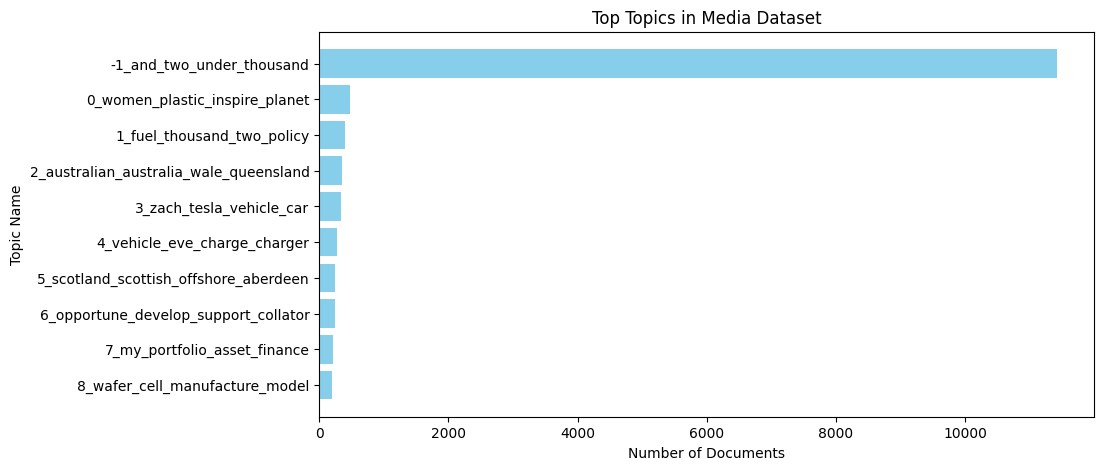

In [9]:
import matplotlib.pyplot as plt

topic_freq = topic_model_media.get_topic_info()
top_n = 10 

plt.figure(figsize=(10, 5))
plt.barh(topic_freq["Name"][:top_n], topic_freq["Count"][:top_n], color="skyblue")
plt.xlabel("Number of Documents")
plt.ylabel("Topic Name")
plt.title("Top Topics in Media Dataset")
plt.gca().invert_yaxis()  
plt.show()


***key insights***:

The majority of documents (11,426) were classified as outliers (Topic -1), meaning they did not fit well into any specific topic.

The remaining topics have much fewer documents, suggesting that the dataset might be highly diverse.
The topics cover different themes, such as climate policy, Tesla vehicles, Australian energy policies, and biomimetics.

#### Conclusion topic modelling:

When looking at the words which appear in all three topic models of the media dataset, we see that there is one word which also appears in the patent dataset beeing: *electro*. The other words have gained media attention but are not patented yet. Furthermore the patented top words are aligned with market trends with those beeing photovoltaic, panel and electro beeing the top words which were found in all three topic modeling methods. 

